# Обработка медицинксих изображений
## Лабораторная работа №4 
## Классификация объектов
Выполнил студент БМТ1-12М     
Колокольников Георгий

# 0. Подготовительный этап

In [23]:
%matplotlib inline

Импортируем требуемые библиотеки

In [24]:
from scipy.signal import convolve2d
from scipy.misc import imread
import scipy.ndimage as ndi

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

import skimage.filters as skmg_filt
import skimage.morphology as skmg_morph
import skimage.measure as skmg_meas
import skimage.color as skmg_color
from skimage import feature

import warnings
warnings.filterwarnings('ignore')

Функция, переводящая цветное изображение в полутоновое

In [25]:
def rgb2norm_gray(rgb):
    """
    Функция переводит 3х-канальное rgb изображение в 
    одноканальное серошкальное
    """
    return (np.dot(rgb[...,:3],[0.299, 0.587, 0.114]))/255

Загрузим и построим изображение

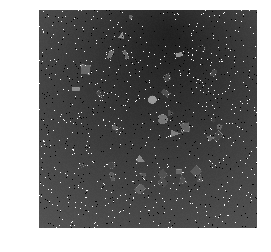

In [26]:
sample_im = rgb2norm_gray(imread('Sample1.png',False, 'RGB' ))
plt.imshow(sample_im, cmap='gray')
plt.axis('off')
plt.show()

# 1. Обработка изображения

Проведем фильтрацию для устранения шумов. Воспользуемся медианным фильтром

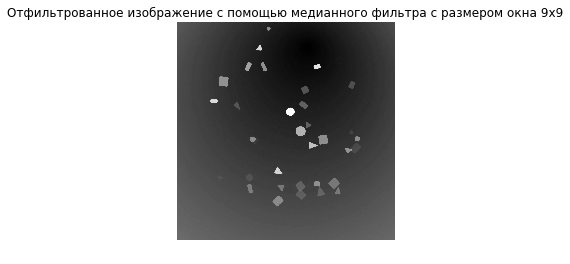

In [27]:
# Размер окна
w = 9

sample_filt = np.empty([sample_im.shape[0], sample_im.shape[1]])

sample_filt = ndi.filters.median_filter(sample_im, w)

plt.imshow(sample_filt, cmap='gray')
plt.axis('off')
plt.title('Отфильтрованное изображение с помощью медианного фильтра с размером окна '+str(w)+'x'+str(w))
plt.show()

Воспользуемся выделением границ с помощью фильтра Кэнни

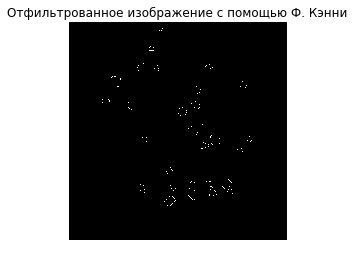

In [28]:
sample_canny = feature.canny(sample_filt, sigma=0.00001)

plt.imshow(sample_canny, cmap='gray')
plt.axis('off')
plt.title('Отфильтрованное изображение с помощью Ф. Кэнни')
plt.show()

Выполним бинаризацию для обоих изображений

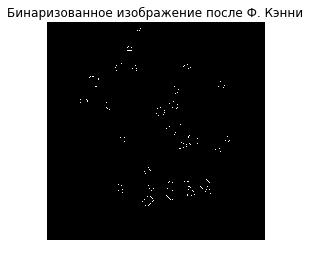

In [29]:
thresh_min = skmg_filt.threshold_mean(sample_canny)
sample_bin = sample_canny > thresh_min

plt.imshow(sample_bin, cmap='gray')
plt.axis('off')
plt.title('Бинаризованное изображение после Ф. Кэнни')
plt.show()

Морфологическая обработка для замыкания контуров

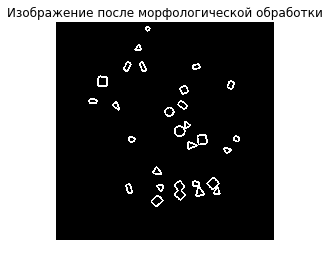

In [30]:
sample_morph = ndi.binary_dilation(sample_bin, structure=skmg_morph.diamond(2), iterations = 2)
sample_morph = ndi.binary_opening(sample_morph, structure=skmg_morph.diamond(2), iterations = 1)

plt.imshow(sample_morph, cmap='gray')
plt.axis('off')
plt.title('Изображение после морфологической обработки')
plt.show()

# 2. Поиск компонент связности и выделение признаков

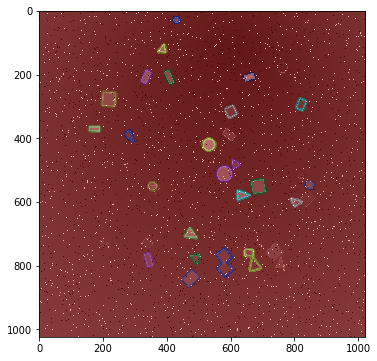

In [31]:
label_image = skmg_meas.label(sample_morph)
image_label_overlay = skmg_color.label2rgb(label_image, image=sample_im)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

In [32]:
regions = skmg_meas.regionprops(label_image)

ВЫделим свойства отмеченных объектов

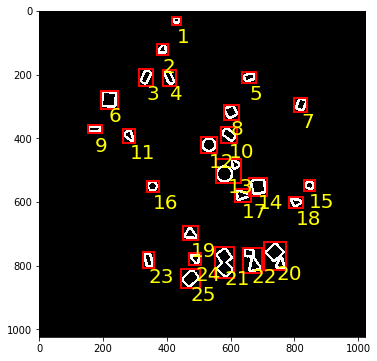

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(sample_morph, cmap='gray')

elem_num = []
elem_center_x = []
elem_center_y = []
elem_eccentricity = []
elem_major_axis = []
elem_minor_axis = []
elem_eq_diameter = []
elem_euler_num = []
elem_extent = []
elem_convex_area = []
elem_area = []
elem_orientation = []

for region in regions:
    
    elem_num.append(region.label)
    elem_center_x.append(region.centroid[1])
    elem_center_y.append(region.centroid[0])
    elem_eccentricity.append(region.eccentricity)
    elem_major_axis.append(region.major_axis_length)
    elem_minor_axis.append(region.minor_axis_length)
    elem_eq_diameter.append(region.equivalent_diameter)
    elem_euler_num.append(region.euler_number)
    elem_extent.append(region.extent)
    elem_convex_area.append(region.convex_area)
    elem_area.append(region.area)
    elem_orientation.append(region.orientation)
    
    minr, minc, maxr, maxc = region.bbox
    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill = False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(region.centroid[1], region.centroid[0]+70, region.label, color = 'yellow', fontsize = 20)
    



Внесем данные об объектав в DataFrame

In [34]:
import pandas as pd
elem_name = 'name'
data_dict = {'1_name':elem_name,'1_number':elem_num, 'class':0, 'x_center':elem_center_x, 'y_center':elem_center_y, 
             'eccentricity':elem_eccentricity, 'delta_axis':np.array(elem_major_axis)- np.array(elem_minor_axis),
             'equivalent_diameter':elem_eq_diameter, 'euler_number':elem_euler_num, 'extent':elem_extent,
             'part_of_convex_area':np.array(elem_area)/np.array(elem_convex_area),'orientation':elem_orientation}

elem_data = pd.DataFrame(data_dict)

Добавим в структуру данных тип фигуры, определенный визуально. Подсчитаем индексы каждой фигуры, внесем в соответствующий список и уменьшим индекс на 1, чтобы нумерация начиналась с 0

In [35]:
circles = np.array([1,12,15,16]) -1
triangles = np.array([2,11,17,18,19,24]) -1
rectangulars = np.array([3,4,5,7,9,10,23,25]) -1
squares = np.array([6,8,14]) -1
mixed = np.array([13,20,21,22]) -1

Заполним таблицу типами фигур

In [36]:
elem_data['1_name'].iloc[circles] = 'circle'
elem_data['1_name'].iloc[triangles] = 'triangle'
elem_data['1_name'].iloc[rectangulars] = 'rectangular'
elem_data['1_name'].iloc[squares] = 'square'
elem_data['1_name'].iloc[mixed] = 'mixed'

Поскольку классификатор оперирует классами в цифровом обозначении, введем классы

In [37]:
elem_data['class'].loc[elem_data['1_name'] == 'circle'] = 0
elem_data['class'].loc[elem_data['1_name'] == 'triangle'] = 1
elem_data['class'].loc[elem_data['1_name'] == 'rectangular'] = 2
elem_data['class'].loc[elem_data['1_name'] == 'square'] = 3
elem_data['class'].loc[elem_data['1_name'] == 'mixed'] = 4

Рассмотим данные, которые были извлечены из изображения

In [38]:
elem_data

,1_name,1_number,class,delta_axis,eccentricity,equivalent_diameter,euler_number,extent,orientation,part_of_convex_area,x_center,y_center
0,circle,1,0,0.263497,0.136794,24.332209,0,0.637860,0.439589,0.859519,430.023656,30.959140
1,triangle,2,1,7.371118,0.575226,29.790065,0,0.568980,0.895216,0.802071,386.760402,122.915352
2,rectangular,3,2,22.407707,0.784431,34.188213,0,0.428571,1.142060,0.687126,334.534858,208.866013
3,rectangular,4,2,27.728242,0.841588,34.132304,0,0.460030,-1.158925,0.723892,407.560656,210.030601
4,rectangular,5,2,13.006587,0.685733,31.655008,0,0.538304,0.290169,0.737582,658.055909,209.514612
5,square,6,3,1.828393,0.224873,42.818979,0,0.467836,1.396352,0.532348,218.407639,278.804861
6,rectangular,7,2,10.457675,0.601108,33.549125,0,0.468717,1.185397,0.671733,820.714932,295.271493
7,square,8,3,1.825143,0.261781,34.925113,0,0.433680,-1.141157,0.623292,600.725470,318.168058
8,rectangular,9,2,18.599750,0.780311,32.094404,0,0.691453,-0.039048,0.788499,172.996292,371.529048
9,rectangular,10,2,18.509154,0.716669,34.410940,0,0.372596,-0.653425,0.618351,594.598925,389.566667


Проанализируем признаки по классам

In [39]:
elem_data.loc[elem_data['1_name']=='circle']

,1_name,1_number,class,delta_axis,eccentricity,equivalent_diameter,euler_number,extent,orientation,part_of_convex_area,x_center,y_center
0,circle,1,0,0.263497,0.136794,24.332209,0,0.637860,0.439589,0.859519,430.023656,30.959140
11,circle,12,0,0.572414,0.140977,36.213764,0,0.428988,-0.449720,0.568433,532.066990,421.167961
14,circle,15,0,2.796605,0.375400,29.163745,0,0.561345,-0.456423,0.758229,847.133234,548.220060
15,circle,16,0,1.053568,0.226469,29.768687,0,0.522523,-0.422980,0.703741,354.833333,551.061782


In [40]:
elem_data.loc[elem_data['1_name']=='triangle']

,1_name,1_number,class,delta_axis,eccentricity,equivalent_diameter,euler_number,extent,orientation,part_of_convex_area,x_center,y_center
1,triangle,2,1,7.371118,0.575226,29.790065,0,0.568980,0.895216,0.802071,386.760402,122.915352
10,triangle,11,1,18.471266,0.771303,31.775446,0,0.462121,-0.931360,0.769156,282.834805,393.853720
16,triangle,17,1,15.958113,0.700498,35.359882,0,0.491000,0.000220,0.727407,635.535642,579.443992
17,triangle,18,1,11.235238,0.664138,30.798757,0,0.509576,-0.277239,0.782563,804.123490,600.774497
18,triangle,19,1,8.821408,0.560958,34.132304,0,0.453869,-0.555758,0.712062,474.575956,701.684153
23,triangle,24,1,5.255089,0.477496,31.493707,0,0.512163,-0.853477,0.757782,489.983312,776.607189


In [41]:
elem_data.loc[elem_data['1_name']=='rectangular']

,1_name,1_number,class,delta_axis,eccentricity,equivalent_diameter,euler_number,extent,orientation,part_of_convex_area,x_center,y_center
2,rectangular,3,2,22.407707,0.784431,34.188213,0,0.428571,1.142060,0.687126,334.534858,208.866013
3,rectangular,4,2,27.728242,0.841588,34.132304,0,0.460030,-1.158925,0.723892,407.560656,210.030601
4,rectangular,5,2,13.006587,0.685733,31.655008,0,0.538304,0.290169,0.737582,658.055909,209.514612
6,rectangular,7,2,10.457675,0.601108,33.549125,0,0.468717,1.185397,0.671733,820.714932,295.271493
8,rectangular,9,2,18.599750,0.780311,32.094404,0,0.691453,-0.039048,0.788499,172.996292,371.529048
9,rectangular,10,2,18.509154,0.716669,34.410940,0,0.372596,-0.653425,0.618351,594.598925,389.566667
22,rectangular,23,2,24.130230,0.802695,35.070634,0,0.530769,-1.334070,0.712389,342.916149,782.428571
24,rectangular,25,2,12.640177,0.570279,37.745928,0,0.305738,0.743266,0.516382,473.947274,839.914209


In [42]:
elem_data.loc[elem_data['1_name']=='square']

,1_name,1_number,class,delta_axis,eccentricity,equivalent_diameter,euler_number,extent,orientation,part_of_convex_area,x_center,y_center
5,square,6,3,1.828393,0.224873,42.818979,0,0.467836,1.396352,0.532348,218.407639,278.804861
7,square,8,3,1.825143,0.261781,34.925113,0,0.433680,-1.141157,0.623292,600.725470,318.168058
13,square,14,3,1.001386,0.171233,41.489997,0,0.446942,-1.216541,0.542536,686.346893,551.857988


In [43]:
elem_data.loc[elem_data['1_name']=='mixed']

,1_name,1_number,class,delta_axis,eccentricity,equivalent_diameter,euler_number,extent,orientation,part_of_convex_area,x_center,y_center
12,mixed,13,4,44.402185,0.819813,49.661504,-1,0.310566,0.733051,0.502334,592.466185,501.886939
19,mixed,20,4,41.179237,0.808301,49.904474,-1,0.335564,-1.148205,0.519798,744.899284,772.876278
20,mixed,21,4,44.484297,0.808054,48.690574,0,0.325354,-1.461952,0.438840,580.776047,790.048335
21,mixed,22,4,53.505045,0.887742,48.032385,-1,0.374690,-1.168183,0.563083,666.366446,781.881898


Поместим признаки с 3 по 9 (начиная отсчет с 0 =)) в массив Numpy, поскольку классификатор работает с таким типом данных. Метки включающие номер класса фигуоы (от 0 до 4) занесем также в другой массив. Среди свойств элементов были выбраны:
- разность длин большой и малой диагоналей;
- эксцентриситет;
- эквивалентный диаметр;
- эйлеровы числа для фигуры;
- степень фигуры (extent);
- часть площади, занимаемая исходной фигуры на фоне области.

In [45]:
X_train = elem_data.iloc[:,3:9].values
Y_train = elem_data.iloc[:,2].values

Очевидно, что выборка из 25 элементов нерепрезентативна, с учетом того, что на некоторые классы приходится всего 3 элемента. Расширим обучающую выборку

# 3. Конвейер предобработки изображения

Напишем фунцию, включающую все этапы предобработки

In [46]:
def image_preprocessing(im_to_process):
    # RGB convertion to Gray
    sample_im = rgb2norm_gray(im_to_process)
    # Filtering
    w = 9
    sample_filt = np.empty([sample_im.shape[0], sample_im.shape[1]])
    sample_filt = ndi.filters.median_filter(sample_im, w)
    # edge detection
    sample_canny = feature.canny(sample_filt, sigma=0.00001)
    # Binarization
    thresh_min = skmg_filt.threshold_mean(sample_canny)
    sample_bin = sample_canny > thresh_min
    # Dilation
    sample_morph = ndi.binary_dilation(sample_bin, structure=skmg_morph.diamond(2), iterations = 2)
    sample_morph = ndi.binary_opening(sample_morph, structure=skmg_morph.diamond(2), iterations = 1)
    
    # Feature extraction
    label_image = skmg_meas.label(sample_morph)
    image_label_overlay = skmg_color.label2rgb(label_image, image=sample_im)
    # Feature engineering
    regions = skmg_meas.regionprops(label_image)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(sample_morph, cmap='gray')
    
    elem_num = []
    elem_center_x = []
    elem_center_y = []
    elem_eccentricity = []
    elem_major_axis = []
    elem_minor_axis = []
    elem_eq_diameter = []
    elem_euler_num = []
    elem_extent = []
    elem_convex_area = []
    elem_area = []
    elem_orientation = []

    for region in regions:
    
        elem_num.append(region.label)
        elem_center_x.append(region.centroid[1])
        elem_center_y.append(region.centroid[0])
        elem_eccentricity.append(region.eccentricity)
        elem_major_axis.append(region.major_axis_length)
        elem_minor_axis.append(region.minor_axis_length)
        elem_eq_diameter.append(region.equivalent_diameter)
        elem_euler_num.append(region.euler_number)
        elem_extent.append(region.extent)
        elem_convex_area.append(region.convex_area)
        elem_area.append(region.area)
        elem_orientation.append(region.orientation)
        
        minr, minc, maxr, maxc = region.bbox
        rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill = False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(region.centroid[1], region.centroid[0]+70, region.label, color = 'yellow', fontsize = 20)
    
    elem_name = 'NaN'
    data_dict = {'1_name':elem_name,'1_number':elem_num, 'class':'NaN', 'x_center':elem_center_x, 'y_center':elem_center_y, 
                 'eccentricity':elem_eccentricity, 'delta_axis':np.array(elem_major_axis)- np.array(elem_minor_axis),
                 'equivalent_diameter':elem_eq_diameter, 'euler_number':elem_euler_num, 'extent':elem_extent,
                 'part_of_convex_area':np.array(elem_area)/np.array(elem_convex_area),'orientation':elem_orientation}

    elem_data = pd.DataFrame(data_dict)
    return elem_data, sample_morph

Считаем новое изображение

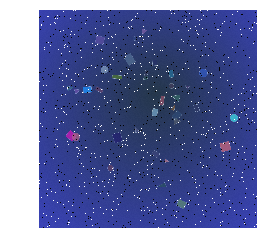

In [47]:
train_image = imread('Samples\Sample15.png',False, 'RGB' )
plt.imshow(train_image, cmap='gray')
plt.axis('off')
plt.show()

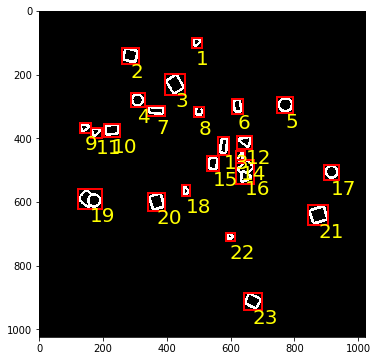

In [48]:
elem_data = image_preprocessing(train_image)[0]

Внесем информацию о классах фигур в данные

In [49]:
circles = np.array([4,5,8,17,22]) -1
triangles = np.array([1,9,11,12,14,18,]) -1
rectangulars = np.array([6,7,10,13,15]) -1
squares = np.array([2,3,20,21,23]) -1
mixed = np.array([16,19]) -1

elem_data['1_name'].iloc[circles] = 'circle'
elem_data['1_name'].iloc[triangles] = 'triangle'
elem_data['1_name'].iloc[rectangulars] = 'rectangular'
elem_data['1_name'].iloc[squares] = 'square'
elem_data['1_name'].iloc[mixed] = 'mixed'

elem_data['class'].loc[elem_data['1_name'] == 'circle'] = 0
elem_data['class'].loc[elem_data['1_name'] == 'triangle'] = 1
elem_data['class'].loc[elem_data['1_name'] == 'rectangular'] = 2
elem_data['class'].loc[elem_data['1_name'] == 'square'] = 3
elem_data['class'].loc[elem_data['1_name'] == 'mixed'] = 4

In [50]:
elem_data

,1_name,1_number,class,delta_axis,eccentricity,equivalent_diameter,euler_number,extent,orientation,part_of_convex_area,x_center,y_center
0,triangle,1,1,3.853148,0.454987,27.800295,0,0.557392,0.776743,0.816958,492.225700,98.499176
1,square,2,3,3.545459,0.327118,39.926131,0,0.437762,-0.263577,0.568316,285.677316,141.133387
2,square,3,3,11.212026,0.526246,40.543215,0,0.315494,-1.046571,0.509270,425.601084,231.745159
3,circle,4,0,0.785958,0.175866,33.832563,0,0.464360,-0.970007,0.619146,307.446051,280.766407
4,circle,5,0,0.142251,0.069310,36.910247,0,0.428000,-0.042818,0.555556,771.329907,296.019626
5,rectangular,6,2,16.684463,0.722917,34.038919,0,0.569462,-1.389884,0.710938,620.423077,299.558242
6,rectangular,7,2,30.289034,0.849845,36.248906,0,0.594470,-0.093749,0.725738,366.499031,313.994186
7,circle,8,0,4.931055,0.513692,25.281738,1,0.539785,-0.155461,0.709040,500.053785,319.161355
8,triangle,9,1,6.205552,0.545653,29.054394,0,0.558081,0.237293,0.810513,141.383107,366.633484
9,rectangular,10,2,11.882739,0.590764,37.830163,0,0.537542,0.100812,0.625139,227.395907,373.680605


Считаем признаки и метки в соответствующие массивы и объединим с предыдущим данными

In [51]:
X_train_2 = elem_data.iloc[:,3:9].values
Y_train_2 = elem_data.iloc[:,2]

In [52]:
X_train = np.append(X_train, X_train_2, axis=0)
Y_train = np.append(Y_train, Y_train_2, axis=0)

Считаем новое изображение

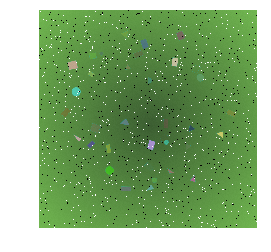

In [61]:
train_image = imread('Samples\Sample12.png',False, 'RGB' )
plt.imshow(train_image, cmap='gray')
plt.axis('off')
plt.show()

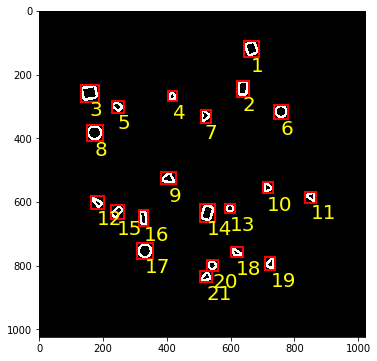

In [62]:
elem_data = image_preprocessing(train_image)[0]

Внесем информацию о классах фигур в данные

In [65]:
circles = np.array([4,6,8,13,17,20]) -1
triangles = np.array([7,9,10,11,12,16,18,19,21]) -1
rectangulars = np.array([2,14,15]) -1
squares = np.array([1,3,5]) -1

elem_data['1_name'].iloc[circles] = 'circle'
elem_data['1_name'].iloc[triangles] = 'triangle'
elem_data['1_name'].iloc[rectangulars] = 'rectangular'
elem_data['1_name'].iloc[squares] = 'square'

elem_data['class'].loc[elem_data['1_name'] == 'circle'] = 0
elem_data['class'].loc[elem_data['1_name'] == 'triangle'] = 1
elem_data['class'].loc[elem_data['1_name'] == 'rectangular'] = 2
elem_data['class'].loc[elem_data['1_name'] == 'square'] = 3

In [66]:
elem_data

,1_name,1_number,class,delta_axis,eccentricity,equivalent_diameter,euler_number,extent,orientation,part_of_convex_area,x_center,y_center
0,square,1,3,6.540192,0.459633,36.615861,0,0.413265,-1.212617,0.604478,664.586895,119.784425
1,rectangular,2,2,14.478774,0.652098,36.493952,0,0.525892,1.404319,0.643296,637.904398,244.169216
2,square,3,3,5.494913,0.396006,40.590294,0,0.444368,0.181407,0.561145,157.459815,258.764297
3,circle,4,0,3.664135,0.454882,27.104598,0,0.601042,-1.496746,0.843567,416.753899,269.422877
4,square,5,3,7.093439,0.563718,28.389446,0,0.475225,-0.704995,0.737762,245.426540,301.406003
5,circle,6,0,0.102179,0.063567,33.964025,0,0.467975,-0.106262,0.615908,757.320088,317.549669
6,triangle,7,1,7.157381,0.563747,29.981780,0,0.538110,-1.569261,0.786192,518.519830,330.470255
7,circle,8,0,0.203748,0.082742,36.927490,0,0.420000,-0.882299,0.551777,173.908497,383.610644
8,triangle,9,1,9.770830,0.597629,33.032806,0,0.469846,-0.131820,0.734362,404.744457,528.352392
9,triangle,10,1,0.651118,0.193203,28.523676,0,0.569519,-0.053664,0.820282,714.696401,556.068858


Считаем признаки и метки в соответствующие массивы и объединим с предыдущим данными

In [67]:
X_train_3 = elem_data.iloc[:,3:9].values
Y_train_3 = elem_data.iloc[:,2]

In [68]:
X_train = np.append(X_train, X_train_3, axis=0)
Y_train = np.append(Y_train, Y_train_3, axis=0)

# 4. Обучение классификатора

Выберем в качестве классификатора решающее дерево и обучем на выборке

In [70]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

clf.fit(X_train, Y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# 5. Тестирование

Считаем тестовое изображение

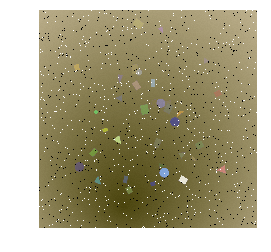

In [71]:
test = imread('Samples\Sample7.png',False, 'RGB' )
plt.imshow(test, cmap='gray')
plt.axis('off')
plt.show()

Выделим свойства иесиового изображения

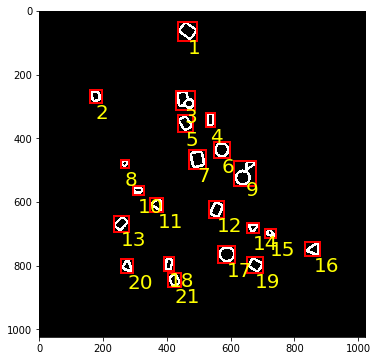

In [72]:
test_data, test_im_processed = image_preprocessing(test)

In [73]:
test_data

,1_name,1_number,class,delta_axis,eccentricity,equivalent_diameter,euler_number,extent,orientation,part_of_convex_area,x_center,y_center
0,NaN,1,NaN,10.901381,0.539173,38.331690,0,0.325989,-0.628323,0.535747,465.381282,64.250433
1,NaN,2,NaN,4.741884,0.449795,31.735351,0,0.534459,-1.270004,0.712613,177.010114,269.204804
2,NaN,3,NaN,22.593177,0.710110,44.766941,-1,0.437222,-0.833886,0.599163,455.935832,281.668996
3,NaN,4,NaN,18.535279,0.770507,32.606058,0,0.687243,1.561084,0.771719,536.014371,342.700599
4,NaN,5,NaN,13.619975,0.636168,35.287792,0,0.391827,-1.026801,0.618596,457.699387,353.861963
5,NaN,6,NaN,0.544774,0.135645,36.754689,0,0.424400,-1.375428,0.558421,571.975495,437.163054
6,NaN,7,NaN,9.689225,0.509666,40.527509,0,0.427719,-1.346100,0.559410,495.626357,466.555039
7,NaN,8,NaN,0.159997,0.112415,22.820056,0,0.654400,0.151825,0.893013,267.014670,479.628362
8,NaN,9,NaN,53.508964,0.870710,47.846470,-1,0.321703,1.052397,0.518006,646.065072,509.238598
9,NaN,10,NaN,8.733818,0.648534,27.570347,0,0.650327,0.165475,0.833799,309.788945,563.085427


Запишем свойства в массив для последующей классификации

In [74]:
X_test = test_data.iloc[:,3:9].values
predicted = clf.predict(X_test)
test_data['class'] = predicted

Поставим в соответствие цифровому обозначению классов названия фигур

In [75]:
test_data['1_name'].loc[test_data['class']==0] = 'circle'
test_data['1_name'].loc[test_data['class']==1] = 'triangle'
test_data['1_name'].loc[test_data['class']==2] = 'rectangular'
test_data['1_name'].loc[test_data['class']==3] = 'square'
test_data['1_name'].loc[test_data['class']==4] = 'mixed'

In [76]:
test_data

,1_name,1_number,class,delta_axis,eccentricity,equivalent_diameter,euler_number,extent,orientation,part_of_convex_area,x_center,y_center
0,triangle,1,1,10.901381,0.539173,38.331690,0,0.325989,-0.628323,0.535747,465.381282,64.250433
1,triangle,2,1,4.741884,0.449795,31.735351,0,0.534459,-1.270004,0.712613,177.010114,269.204804
2,mixed,3,4,22.593177,0.710110,44.766941,-1,0.437222,-0.833886,0.599163,455.935832,281.668996
3,rectangular,4,2,18.535279,0.770507,32.606058,0,0.687243,1.561084,0.771719,536.014371,342.700599
4,rectangular,5,2,13.619975,0.636168,35.287792,0,0.391827,-1.026801,0.618596,457.699387,353.861963
5,circle,6,0,0.544774,0.135645,36.754689,0,0.424400,-1.375428,0.558421,571.975495,437.163054
6,square,7,3,9.689225,0.509666,40.527509,0,0.427719,-1.346100,0.559410,495.626357,466.555039
7,circle,8,0,0.159997,0.112415,22.820056,0,0.654400,0.151825,0.893013,267.014670,479.628362
8,mixed,9,4,53.508964,0.870710,47.846470,-1,0.321703,1.052397,0.518006,646.065072,509.238598
9,triangle,10,1,8.733818,0.648534,27.570347,0,0.650327,0.165475,0.833799,309.788945,563.085427


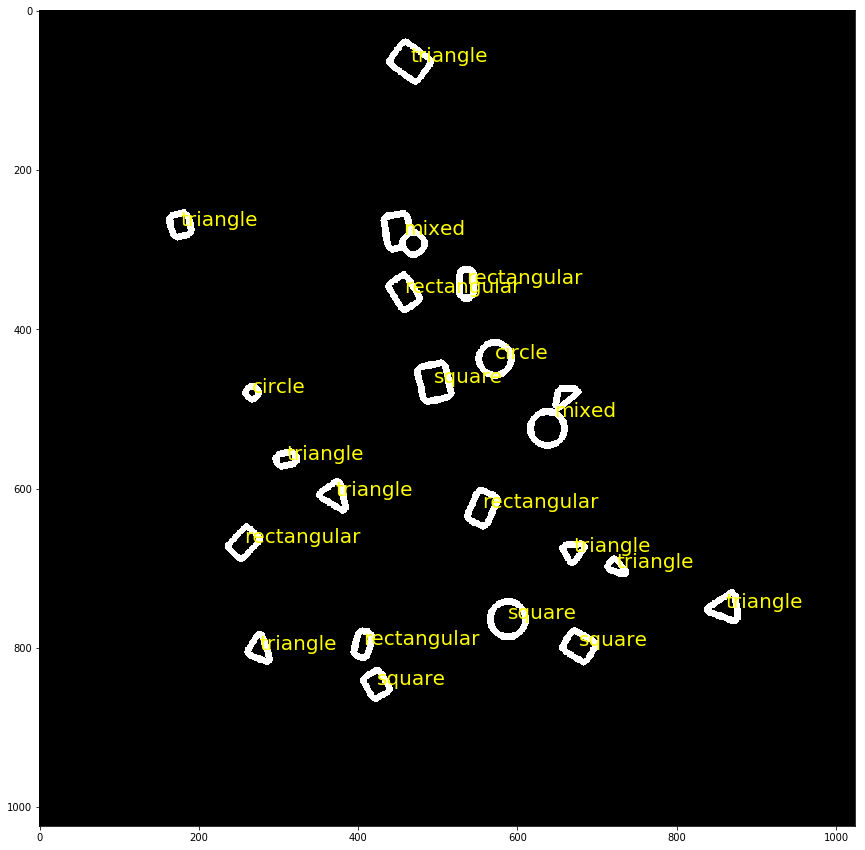

In [77]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(test_im_processed, cmap='gray')
for i in test_data.index:
    ax.text(test_data['x_center'].iloc[i], test_data['y_center'].iloc[i], test_data['1_name'].iloc[i], color = 'yellow', fontsize = 20)

Наблюдаются 3 ошибки на тестовой выборке: в верхней части некорректно определются квадраты, внизу - круг. Всего фигур 21. Следовательно, точность классификации составляет:

In [79]:
1-3/21

0.8571428571428572

Объем обучающей выборки:

In [80]:
X_train.shape

(69, 6)

# Заключение

Таким образом, с помощью решающего дерева и обучающей выборки c 69 элементами получена точность классификации в 86%

Для повышения точности следует:
- увеличить размер обучающей выборки;
- провести анализ информативности (корреляции) признаков;
- подобрать модель классификатора и его гиперпараметры.